<a href="https://www.kaggle.com/code/tolawuwo/unemployment-vs-participation-rate-in-the-us?scriptVersionId=172245645" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
This is a brief Exploratory Data Analysis(EDA) to explore the relationship between unemployment and labor force participation in the US. Unemployment refers to the percentage of people who are actively seeking employment but are currently without a job. Labor force participation refers to the percentage of the working-age population that is either employed or actively seeking employment.

## Installing Fred API package

In [1]:
!pip install fredapi > /dev/null

## Install the neccessary package required for the EDA 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import time

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()
fred_key = secrets.get_secret('fred-api')

### Create the Fred Object

In [3]:
fred = Fred(api_key=fred_key)

### Browse the data for "Unemployment rate per states United States"

Search through the dataset to extract unemployment rate data for each state.

In [4]:
unemp_df = fred.search('unemployment rate by state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains("Unemployment Rate in")]

### Check the data
Basic data quality checks...quick glimpse of the data

In [5]:
unemp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, CAUR to CNEWUR
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         59 non-null     object        
 1   realtime_start             59 non-null     datetime64[ns]
 2   realtime_end               59 non-null     datetime64[ns]
 3   title                      59 non-null     object        
 4   observation_start          59 non-null     datetime64[ns]
 5   observation_end            59 non-null     datetime64[ns]
 6   frequency                  59 non-null     object        
 7   frequency_short            59 non-null     object        
 8   units                      59 non-null     object        
 9   units_short                59 non-null     object        
 10  seasonal_adjustment        59 non-null     object        
 11  seasonal_adjustment_short  59 non-null     object        
 12  last_upd

### Preparing the data for Unemployment rate per state

In [6]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Slowing doing the API request
unemp_states = pd.concat(all_results, axis=1)\
    .drop((['LASMT261982000000003', 
            'LASMT391746000000003', 
            'PRUR', 
            'CMWRUR', 
            'CSOUUR', 
            'CNERUR', 
            'CWSTUR', 
            'CNEWUR']), 
           axis=1)

Replace the id of the states with the full state names as seen in the "title" column.

In [7]:
id_to_states = unemp_df['title'].str.replace('Unemployment Rate in ', '').to_dict()
unemp_states.columns = [id_to_states[c] for c in unemp_states.columns]
unemp_states = unemp_states.rename(columns={"the District of Columbia" : "District Of Columbia"})

### Plot unemployment rate of all the states.

In [8]:
fig = px.line(unemp_states)
fig.show()

### Plot of the unployment rate in April 2020

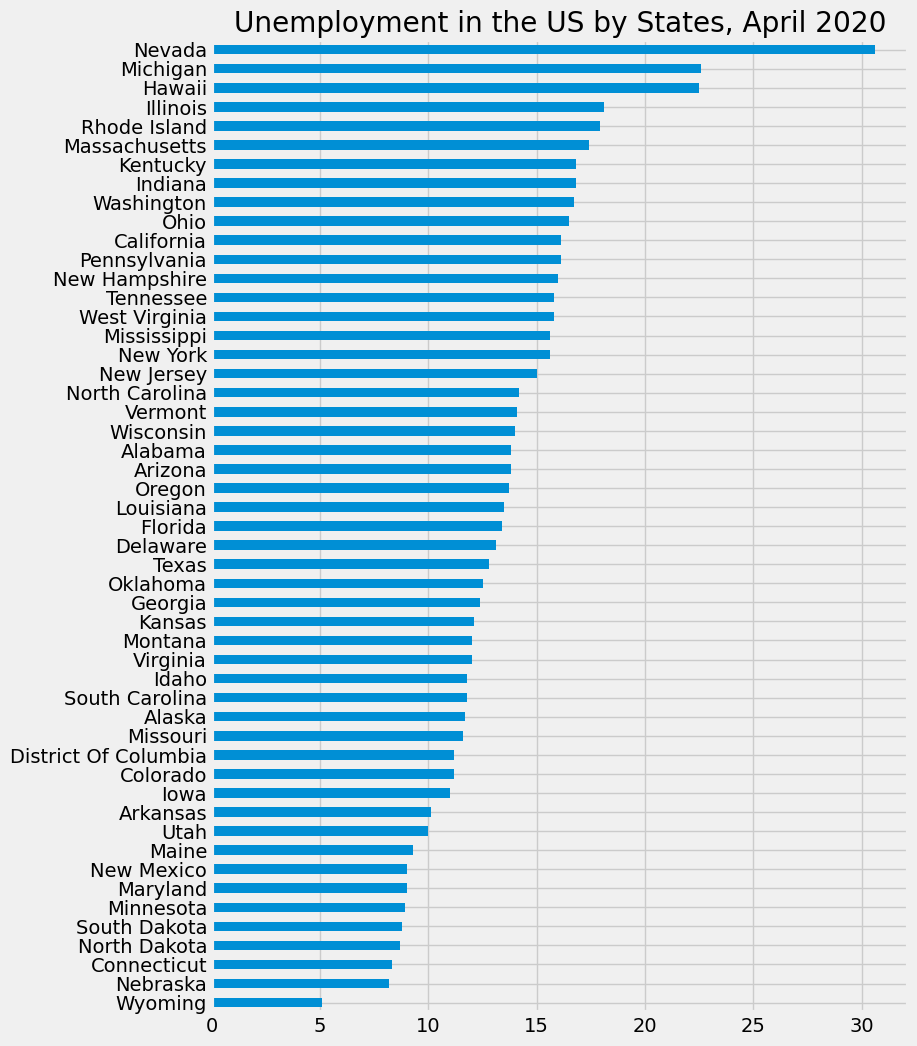

In [9]:
ax = unemp_states.loc[unemp_states.index == '2020-04-01'].T \
    .sort_values('2020-04-01') \
    .plot(kind='barh', figsize=(8, 12),
         title= "Unemployment in the US by States, April 2020")
ax.legend().remove()
plt.show()

Upon closer examination of the drop around April 2020, it can be observed that the COVID-19 pandemic significantly impacted the unemployment rate. Nevada experienced the most pronounced impact, whereas Wyoming was the least affected.

## Browse the Fred dataset for "Participation rate" per states United States"

In [10]:
# Participation rate
part_df = fred.search('participation rate by state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
part_df = part_df.loc[part_df['title'].str.contains("Labor Force Participation Rate for")]

In [11]:
part_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, LBSSA06 to LBSSA56
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype                    
---  ------                     --------------  -----                    
 0   id                         51 non-null     object                   
 1   realtime_start             51 non-null     datetime64[ns]           
 2   realtime_end               51 non-null     datetime64[ns]           
 3   title                      51 non-null     object                   
 4   observation_start          51 non-null     datetime64[ns]           
 5   observation_end            51 non-null     datetime64[ns]           
 6   frequency                  51 non-null     object                   
 7   frequency_short            51 non-null     object                   
 8   units                      51 non-null     object                   
 9   units_short                51 non-null     object                   
 10

In [12]:
part_all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    part_all_results.append(results)
part_states = pd.concat(part_all_results, axis=1)

part_id_to_states = part_df['title'].str.replace('Labor Force Participation Rate for ', '').to_dict()
part_states.columns = [part_id_to_states[c] for c in part_states.columns]

In [13]:
fig = px.line(part_states)
fig.show()

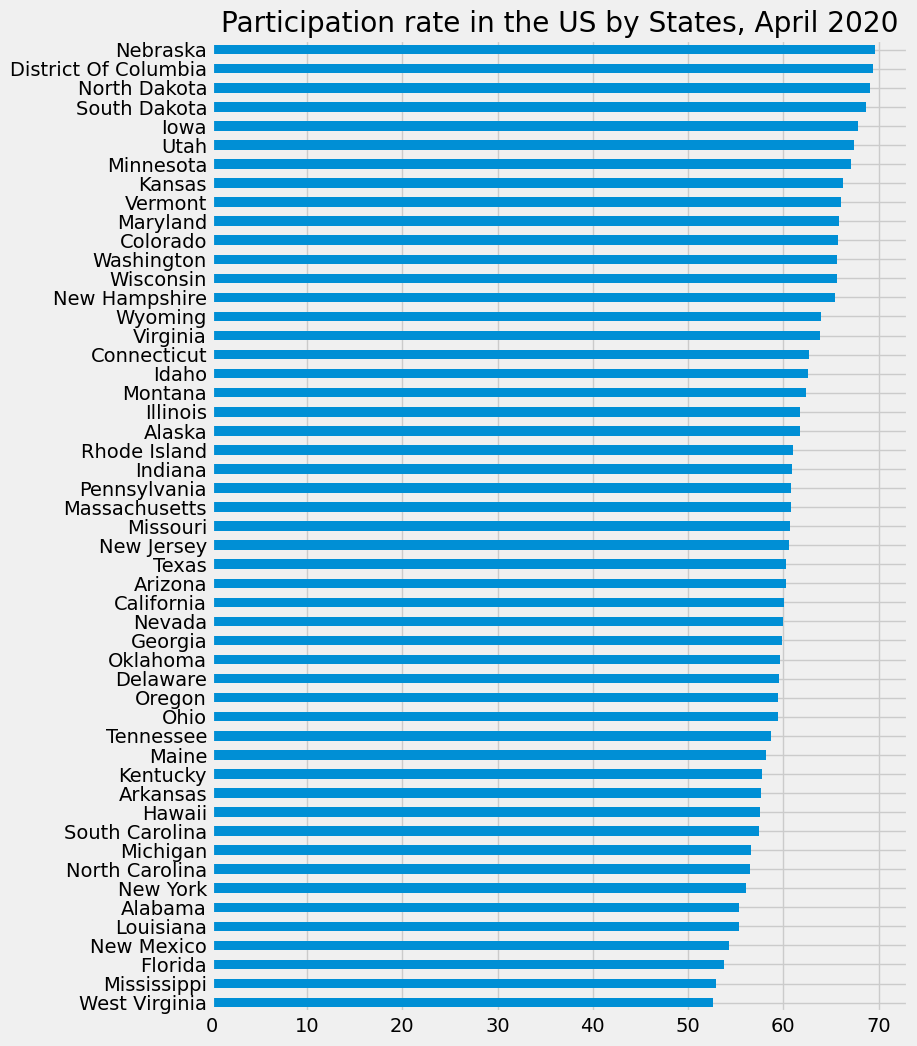

In [14]:
ax = part_states.loc[part_states.index == '2020-04-01'].T \
    .sort_values('2020-04-01') \
    .plot(kind='barh', figsize=(8, 12),
         title= "Participation rate in the US by States, April 2020")
ax.legend().remove()
plt.show()

# Plot Unemployment vs Participation

### Plot for 50 states (excluding "District Of Columbia")

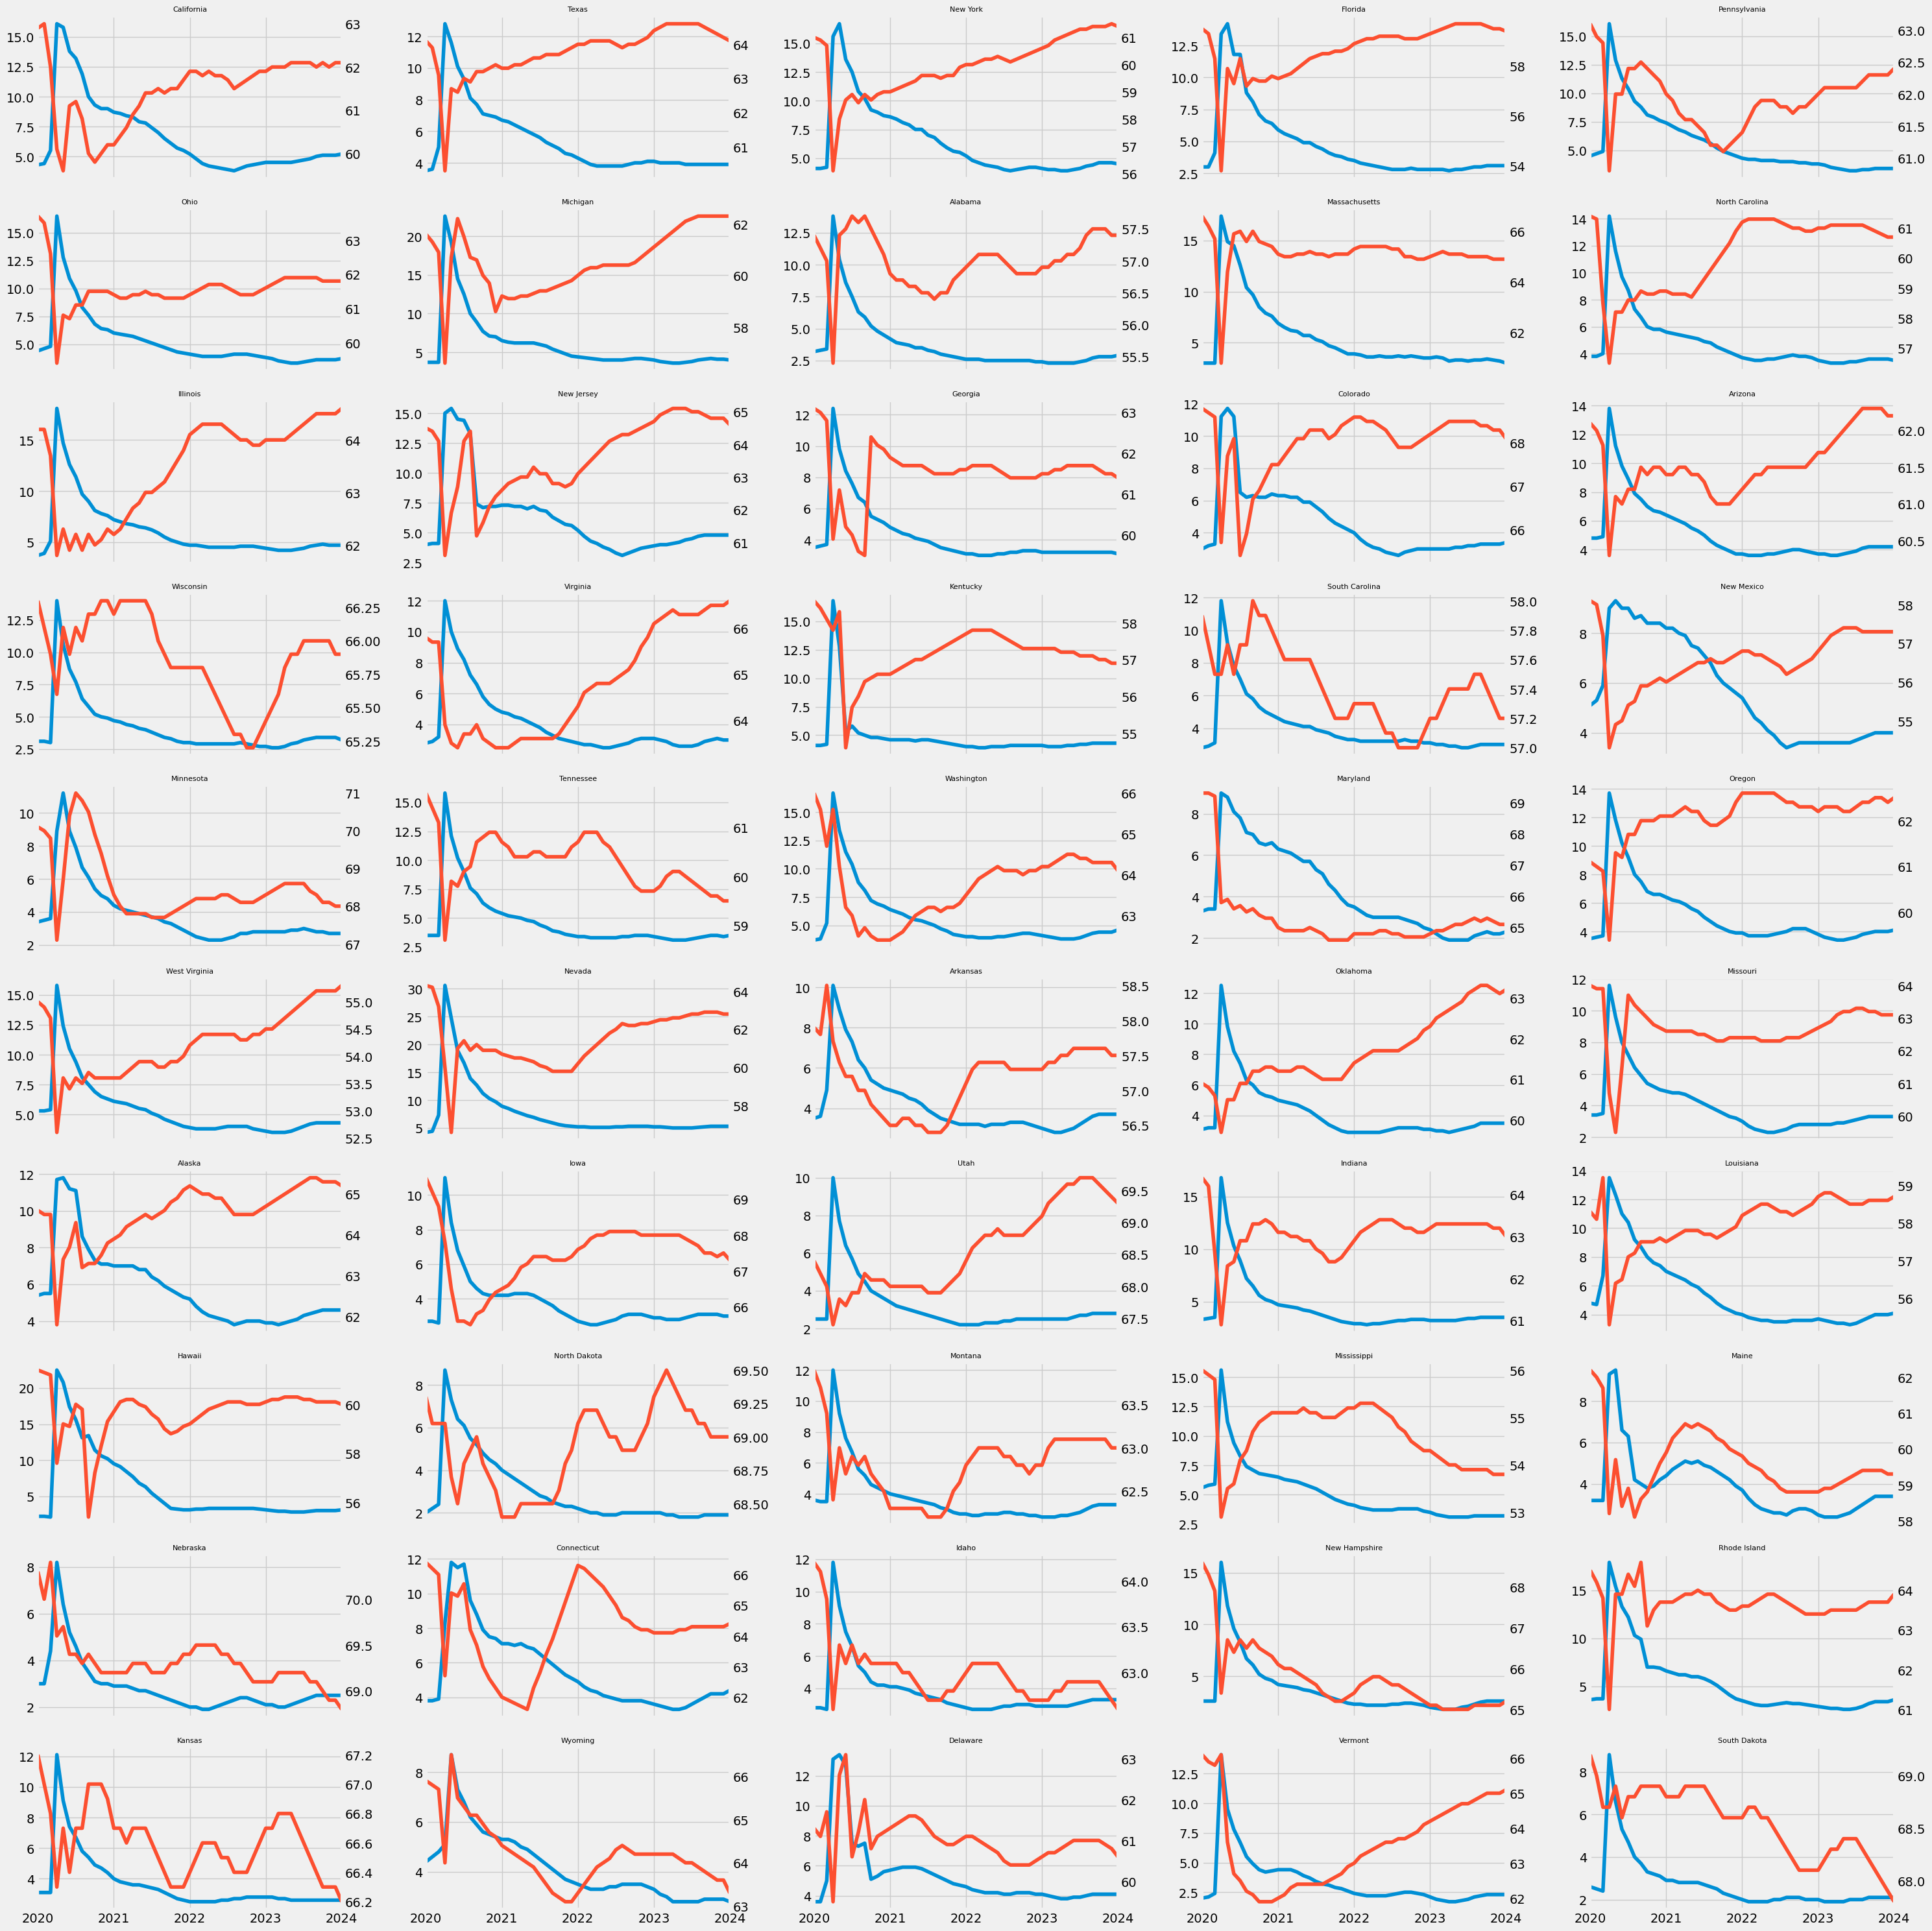

In [15]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in unemp_states.columns:
    if state == "District Of Columbia":
        continue
    ax2 = axs[i].twinx()
    unemp_states.query('index >= 2020 and index <= 2024')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index <= 2024')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state, fontsize=8)
    i += 1
plt.tight_layout()
plt.show()

### Plot for "District Of Columbia"

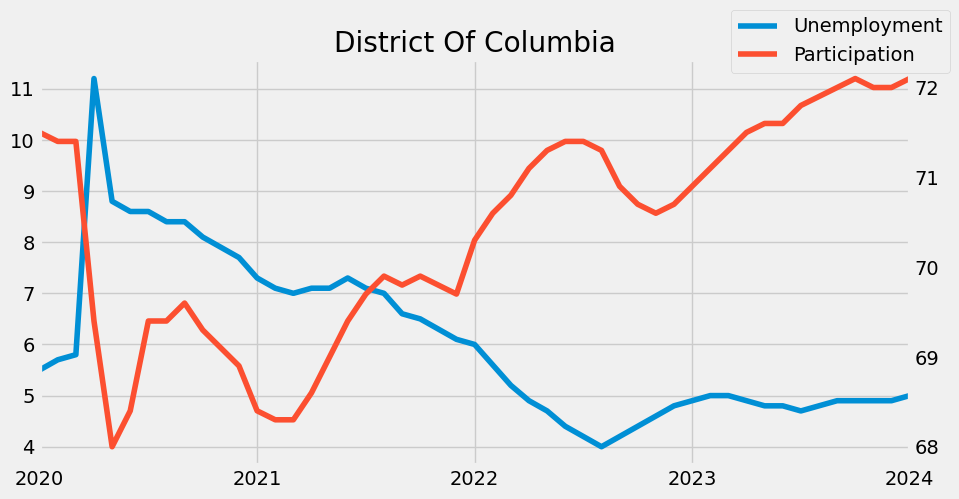

In [16]:
state_dc = 'District Of Columbia'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
unemp_states.query('index >= 2020 and index <= 2024')[state_dc] \
    .plot(ax=ax, label='Unemployment')
part_states.query('index >= 2020 and index <= 2024')[state_dc] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state_dc)
fig.legend(labels=['Unemployment','Participation'])
plt.show();

# Summary and Conclusion

In conclusion, the relationship between unemployment and labor force participation measures can vary based on economic conditions and demographic factors. Generally, during periods of economic downturns or recessions, both the unemployment rate and the labor force participation rate may increase. The plot above is between 2020 and 2024 and we can see the relationship between the unemployment rate and the labor force participation rate particulary around April 2020, shortly after we many states annouced Covid-19 locked-down.

Please feel free to explore further and let me know your thoughts or questions.